In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from tqdm import tqdm
from pymongo import MongoClient
from packaging.version import Version
%matplotlib inline
%config InlineBackend.figure_format = "svg"
print(pd.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.3.4
0.11.2
3.5.0


## Load Data

In [2]:
ms_df = pd.read_csv('data/mindspore.csv')
ms_df['framework'] = 'mindspore'
ms_df['dependent_number'] = ms_df['dependent_number'].fillna(0).astype(int)
pp_df = pd.read_csv('data/paddlepaddle.csv')
pp_df['framework'] = 'paddlepaddle'
pp_df['dependent_number'] = pp_df['dependent_number'].fillna(0).astype(int)
torch_df = pd.read_csv('data/torch.csv')
torch_df['framework'] = 'pytorch'
torch_df['dependent_number'] = torch_df['dependent_number'].fillna(0).astype(int)
tf_df = pd.read_csv('data/tensorflow.csv')
tf_df['framework'] = 'tensorflow'
tf_df['dependent_number'] = tf_df['dependent_number'].fillna(0).astype(int)
all_df = pd.concat([ms_df, pp_df, torch_df, tf_df], ignore_index=True)
print('Toal number of packages in each SC:')
print(len(ms_df), len(pp_df), len(torch_df), len(tf_df), len(all_df))

ms_packages = set(ms_df['name'].unique())
pp_packages = set(pp_df['name'].unique())
torch_packages = set(torch_df['name'].unique())
tf_packages = set(tf_df['name'].unique())
all_packages = set(all_df['name'].unique())
print('Total number of unique packages in each SC:')
print(len(ms_packages), len(pp_packages), len(
    torch_packages), len(tf_packages), len(all_packages))

Toal number of packages in each SC:
13 121 5926 5622 11682
Total number of unique packages in each SC:
13 82 3494 3602 6251


## Package Types

In [3]:
# Here I remove packages without summary and urls
ms_df_with_summary_url = ms_df[(pd.notna(ms_df['summary'])) | (pd.notna(ms_df['home_page'])) | (pd.notna(ms_df['download_url'])) | 
                               (ms_df['project_urls'].str.len() > 2)]
pp_df_with_summary_url = pp_df[(pd.notna(pp_df['summary'])) | (pd.notna(pp_df['home_page'])) | (pd.notna(pp_df['download_url'])) | 
                               (pp_df['project_urls'].str.len() > 2)]
torch_df_with_summary_url = torch_df[(pd.notna(torch_df['summary'])) | (pd.notna(torch_df['home_page'])) | 
                                     (pd.notna(torch_df['download_url'])) | (torch_df['project_urls'].str.len() > 2)]
tf_df_with_summary_url = tf_df[(pd.notna(tf_df['summary'])) | (pd.notna(tf_df['home_page'])) | (pd.notna(tf_df['download_url'])) | 
                               (tf_df['project_urls'].str.len() > 2)]
pd.concat([ms_df_with_summary_url, pp_df_with_summary_url, torch_df_with_summary_url, 
           tf_df_with_summary_url]).groupby(['layer']).size()

layer
1      19
2    5467
3    5101
4     634
5     173
6      17
dtype: int64

In [4]:
samples = pd.DataFrame()
samples = samples.append([pd.concat([torch_df_with_summary_url[torch_df_with_summary_url['layer'] == i].sample(frac=0.1, random_state=1),
                          tf_df_with_summary_url[tf_df_with_summary_url['layer'] == i].sample(frac=0.1, random_state=1)], ignore_index=True)
               for i in range(2, 6)], ignore_index=True)
print('tensorflow samples:', len(samples[samples['framework'] == 'tensorflow']), 
      'pytorch samples', len(samples[samples['framework'] == 'pytorch']))
samples = samples.append([ms_df_with_summary_url[ms_df_with_summary_url['layer'] > 1], 
                         pp_df_with_summary_url[pp_df_with_summary_url['layer'] > 1]] )
samples = samples.append([torch_df_with_summary_url[torch_df_with_summary_url['layer'] == 6],
                          tf_df_with_summary_url[tf_df_with_summary_url['layer'] == 6]])
print('Total samples:', len(samples))
samples.to_excel('data/samples.xlsx', index=False)

tensorflow samples: 547 pytorch samples 578
Total samples: 1269


In [5]:
samples.groupby(['layer']).size()

layer
2    636
3    533
4     65
5     18
6     17
dtype: int64

In [6]:
labelled_packages = pd.read_excel('data/labelled_samples.xlsx')
labelled_packages.head()

,name,summary,home_page,project_urls,download_url,layer,dependent_number,dependency,framework,DR/NDR,Category,Subcategory,Comment
0,cogdl,An Extensive Research Toolkit for Deep Learnin...,https://github.com/THUDM/cogdl,[],NaN,2,1,torch,pytorch,DR,Other,NaN,Graph
1,pau,Pade Activation Unit,https://github.com/alejandromolinaml/SPFlow,[],NaN,2,0,torch,pytorch,NDR,Model,NaN,NaN
2,ai-core,Allows you to focus on building applications u...,https://github.com/AI-Core/ai-core,[],NaN,2,0,torch,pytorch,NDR,Framework,NaN,NaN
3,circFL-deep,circFL-deep: a tool for full-length circRNA is...,https://github.com/yangence/circFL-deep,[],NaN,2,0,torch,pytorch,DR,Biology,NaN,404
4,fonduer,Knowledge base construction system for richly ...,https://github.com/HazyResearch/fonduer,"['Tracker, https://github.com/HazyResearch/fon...",NaN,2,0,torch,pytorch,DR,NLP,NaN,NaN


In [7]:
labelled_packages.groupby(['layer']).size()

layer
2    602
3    369
4     60
5     16
6     14
dtype: int64

In [8]:
labelled_packages.groupby(['layer', 'DR/NDR'])["dependent_number"].mean()

layer  DR/NDR
2      DR        0.393293
       NDR       0.461538
       \         0.164557
3      DR        0.229665
       NDR       0.762376
       \         0.203390
4      DR        0.368421
       NDR       0.357143
       \         0.000000
5      DR        0.071429
       NDR       0.000000
       \         0.000000
6      DR        0.000000
       NDR       0.000000
       \         0.000000
Name: dependent_number, dtype: float64

In [9]:
def overall_layer(layer: int):
    print("Layer {}:".format(layer))
    dr, ndr, Unknown = 0, 0, 0
    
    df1 = labelled_packages[labelled_packages['layer'] == layer]
    ptc = len(torch_df_with_summary_url[torch_df_with_summary_url['layer'] == layer])
    tf = len(tf_df_with_summary_url[tf_df_with_summary_url['layer'] == layer])
    ms = len(ms_df_with_summary_url[ms_df_with_summary_url['layer'] == layer])
    pp = len(pp_df_with_summary_url[pp_df_with_summary_url['layer'] == layer])
    print("PyTorch: {}, TensorFlow: {}, MindSpore: {}, PaddlePaddle: {}".format(ptc, tf, ms, pp))
    
    dr += int(len(df1[(df1['framework'] == 'pytorch') & (df1['DR/NDR'] == 'DR')]) / len(df1[(df1['framework'] == 'pytorch')]) * ptc)
    ndr += int(len(df1[(df1['framework'] == 'pytorch') & (df1['DR/NDR'] == 'NDR')]) / len(df1[(df1['framework'] == 'pytorch')]) * ptc)
    Unknown += int(len(df1[(df1['framework'] == 'pytorch') & (df1['DR/NDR'] == '\\')]) / len(df1[(df1['framework'] == 'pytorch')]) * ptc)
    dr += int(len(df1[(df1['framework'] == 'tensorflow') & (df1['DR/NDR'] == 'DR')]) / len(df1[(df1['framework'] == 'tensorflow')]) * tf)
    ndr += int(len(df1[(df1['framework'] == 'tensorflow') & (df1['DR/NDR'] == 'NDR')]) / len(df1[(df1['framework'] == 'tensorflow')]) * tf)
    Unknown += int(len(df1[(df1['framework'] == 'tensorflow') & (df1['DR/NDR'] == '\\')]) / len(df1[(df1['framework'] == 'tensorflow')]) * tf)
    dr += len(df1[(df1['framework'] == 'paddlepaddle') & (df1['DR/NDR'] == 'DR')])
    ndr += len(df1[(df1['framework'] == 'paddlepaddle') & (df1['DR/NDR'] == 'NDR')])
    Unknown += len(df1[(df1['framework'] == 'paddlepaddle') & (df1['DR/NDR'] == '\\')])
    dr += len(df1[(df1['framework'] == 'mindspore') & (df1['DR/NDR'] == 'DR')])
    ndr += len(df1[(df1['framework'] == 'mindspore') & (df1['DR/NDR'] == 'NDR')])
    Unknown += len(df1[(df1['framework'] == 'mindspore') & (df1['DR/NDR'] == '\\')])
    print("DR: {}, NDR: {}, Unknown: {}".format(dr, ndr, Unknown))
    s = dr + ndr + Unknown
    print("DR: {:.1f}, NDR: {:.1f},Unknown: {:.1f}".format(100 *dr / s, 100 * ndr / s, 100 * Unknown / s))

In [10]:
overall_layer(2)
overall_layer(3)
overall_layer(4)
overall_layer(5)
overall_layer(6)

Layer 2:
PyTorch: 2894, TensorFlow: 2473, MindSpore: 10, PaddlePaddle: 90
DR: 3051, NDR: 1747, Unknown: 647
DR: 56.0, NDR: 32.1,Unknown: 11.9
Layer 3:
PyTorch: 2740, TensorFlow: 2336, MindSpore: 0, PaddlePaddle: 25
DR: 3009, NDR: 1402, Unknown: 682
DR: 59.1, NDR: 27.5,Unknown: 13.4
Layer 4:
PyTorch: 127, TensorFlow: 505, MindSpore: 0, PaddlePaddle: 2
DR: 404, NDR: 152, Unknown: 75
DR: 64.0, NDR: 24.1,Unknown: 11.9
Layer 5:
PyTorch: 16, TensorFlow: 157, MindSpore: 0, PaddlePaddle: 0
DR: 150, NDR: 11, Unknown: 11
DR: 87.2, NDR: 6.4,Unknown: 6.4
Layer 6:
PyTorch: 2, TensorFlow: 15, MindSpore: 0, PaddlePaddle: 0
DR: 7, NDR: 5, Unknown: 5
DR: 41.2, NDR: 29.4,Unknown: 29.4


{'Layer2': [56.0, 32.1, 11.9], 'Layer3': [59.0, 27.5, 13.5], 'Layer4': [63.8, 24.1, 12.1], 'Layer5': [88.0, 6.0, 6.0], 'Layer6': [42.8, 28.6, 28.6]}


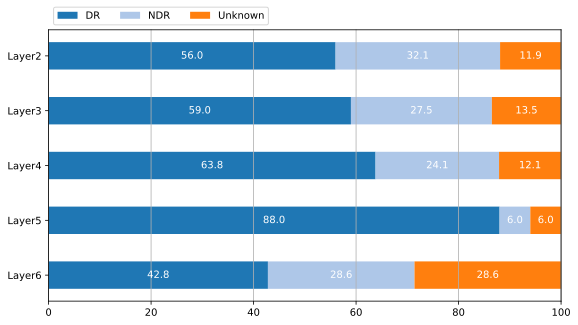

In [11]:
import numpy as np
results = {"Layer2": [56.0, 32.1, 11.9],
         "Layer3": [59.0, 27.5, 13.5],
         "Layer4": [63.8, 24.1, 12.1],
         "Layer5": [88.0, 6.0, 6.0],
         "Layer6": [42.8, 28.6, 28.6]}
category_names = ['DR', 'NDR', 'Unknown']
print(results)
def horizon_bar(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('tab20')(list(range(0, data.shape[1])))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(True)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    ax.grid(True, axis='x')

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(c), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left')

    return fig, ax


fig, _ = horizon_bar(results, category_names)
fig.savefig('figures/dr_ndr.pdf', bbox_inches='tight')
plt.show()

In [12]:
def overall_category(layer: int):
    print("Layer {}:".format(layer))
    df1 = labelled_packages[labelled_packages['layer'] == layer]
    dr_categories = df1[df1['DR/NDR'] == 'DR']['Category'].unique()
    ndr_categories = df1[df1['DR/NDR'] == 'NDR']['Category'].unique()
    dr_res = {}
    ndr_res = {}
    for c in dr_categories:
        dr_res[c] = 0
    for c in ndr_categories:
        ndr_res[c] = 0
    
    ptc = len(torch_df_with_summary_url[torch_df_with_summary_url['layer'] == layer])
    tf = len(tf_df_with_summary_url[tf_df_with_summary_url['layer'] == layer])
    ms = len(ms_df_with_summary_url[ms_df_with_summary_url['layer'] == layer])
    pp = len(pp_df_with_summary_url[pp_df_with_summary_url['layer'] == layer])
    print("PyTorch: {}, TensorFlow: {}, MindSpore: {}, PaddlePaddle: {}".format(ptc, tf, ms, pp))
    
    sample_ptc = df1[(df1['framework'] == 'pytorch')]
    sample_tf = df1[(df1['framework'] == 'tensorflow')]
    print("Sample PyTorch: {}, Sample TensorFlow: {}".format(len(sample_ptc), len(sample_tf)))
    
    for c in dr_categories:
        dr_res[c] += int(len(sample_ptc[sample_ptc['Category'] == c]) / len(sample_ptc) * ptc)
        dr_res[c] += int(len(sample_tf[sample_tf['Category'] == c]) / len(sample_tf) * tf)
        dr_res[c] += len(df1[(df1['framework'] == 'paddlepaddle') & (df1['Category'] == c)])
        dr_res[c] += len(df1[(df1['framework'] == 'mindspore') & (df1['Category'] == c)])
    for c in ndr_categories:
        ndr_res[c] += int(len(sample_ptc[sample_ptc['Category'] == c]) / len(sample_ptc) * ptc)
        ndr_res[c] += int(len(sample_tf[sample_tf['Category'] == c]) / len(sample_tf) * tf)
        ndr_res[c] += len(df1[(df1['framework'] == 'paddlepaddle') & (df1['Category'] == c)])
        ndr_res[c] += len(df1[(df1['framework'] == 'mindspore') & (df1['Category'] == c)])
    # dr_res = sorted(dr_res.items(), key = lambda x: x[1], reverse=True)
    # ndr_res = sorted(ndr_res.items(), key = lambda x: x[1], reverse=True)
    
    return dr_res, ndr_res

In [13]:
dr_res2, ndr_res2 = overall_category(2)
print(dr_res2, ndr_res2)
dr_res3, ndr_res3 = overall_category(3)
print(dr_res3, ndr_res3)
dr_res4, ndr_res4 = overall_category(4)
print(dr_res4, ndr_res4)
dr_res5, ndr_res5 = overall_category(5)
print(dr_res5, ndr_res5)
dr_res6, ndr_res6 = overall_category(6)
print(dr_res6, ndr_res6)

Layer 2:
PyTorch: 2894, TensorFlow: 2473, MindSpore: 10, PaddlePaddle: 90
Sample PyTorch: 287, Sample TensorFlow: 234
{'Other': 117, 'Biology': 380, 'NLP': 832, 'CV': 733, 'Chemistry': 72, 'Medicine': 205, 'Time Series': 91, 'Audio': 174, 'RL': 220, 'Physics': 145, 'RecSys': 73} {'Model': 329, 'Framework': 241, 'Data': 144, 'Monitoring': 186, 'Optimization': 82, 'Compression': 51, 'Explainability': 94, 'Training': 145, 'Robustness': 20, 'Benchmark': 30, 'Wrapper': 187, 'Privacy': 33, 'Conversion': 43, 'Tutorial': 10, 'AutoML': 41, 'Deployment': 101}
Layer 3:
PyTorch: 2740, TensorFlow: 2336, MindSpore: 0, PaddlePaddle: 25
Sample PyTorch: 190, Sample TensorFlow: 159
{'NLP': 930, 'CV': 697, 'Other': 202, 'Medicine': 188, 'RecSys': 101, 'Biology': 304, 'Physics': 130, 'RL': 189, 'Audio': 158, 'Chemistry': 72, 'Time Series': 28} {'Framework': 248, 'Deployment': 118, 'Monitoring': 189, 'Federated': 14, 'Data': 72, 'Model': 174, 'Wrapper': 114, 'Training': 72, 'Compression': 14, 'AutoML': 102

In [14]:
len(labelled_packages[labelled_packages['Category'] == 'Chemistry'])

13

In [15]:
dr_categories = labelled_packages[labelled_packages['DR/NDR'] == 'DR']['Category'].unique()
ndr_categories = labelled_packages[labelled_packages['DR/NDR'] == 'NDR']['Category'].unique()
dr_results = {}
ndr_results = {}
dr_layer2_cnt = sum(dr_res2.values())
dr_layer3_cnt = sum(dr_res3.values())
dr_layer4_cnt = sum(dr_res4.values())
dr_layer5_cnt = sum(dr_res5.values())
dr_layer6_cnt = sum(dr_res6.values())
ndr_layer2_cnt = sum(ndr_res2.values())
ndr_layer3_cnt = sum(ndr_res3.values())
ndr_layer4_cnt = sum(ndr_res4.values())
ndr_layer5_cnt = sum(ndr_res5.values())
ndr_layer6_cnt = sum(ndr_res6.values())
for c in dr_categories:
    dr_results[c] = []
    dr_results[c].append(float('%.1f' % (100*dr_res2.get(c, 0) / dr_layer2_cnt)))
    dr_results[c].append(float('%.1f' % (100*dr_res3.get(c, 0) / dr_layer3_cnt)))
    dr_results[c].append(float('%.1f' % (100*dr_res4.get(c, 0) / dr_layer4_cnt)))
    # dr_results[c].append(float('%.1f' % (100*dr_res5.get(c, 0) / dr_layer5_cnt)))
    # dr_results[c].append(float('%.1f' % (100*dr_res6.get(c, 0) / dr_layer6_cnt)))
for c in ndr_categories:
    ndr_results[c] = []
    ndr_results[c].append(float('%.1f' % (100*ndr_res2.get(c, 0) / ndr_layer2_cnt)))
    ndr_results[c].append(float('%.1f' % (100*ndr_res3.get(c, 0) / ndr_layer3_cnt)))
    ndr_results[c].append(float('%.1f' % (100*ndr_res4.get(c, 0) / ndr_layer4_cnt)))
    # ndr_results[c].append(float('%.1f' % (100*ndr_res5.get(c, 0) / ndr_layer5_cnt)))
    # ndr_results[c].append(float('%.1f' % (100*ndr_res6.get(c, 0) / ndr_layer6_cnt)))


In [16]:
print(len([k for k, _ in sorted(ndr_results.items(), key=lambda x: x[1][0], reverse=True)]))

17


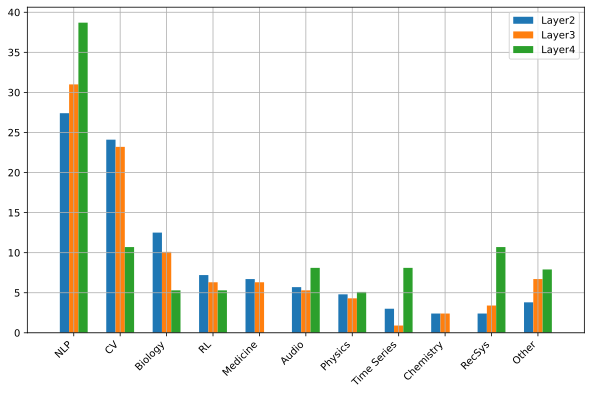

In [17]:
fig = plt.figure(figsize=(10, 6))
dr_names = ['NLP', 'CV', 'Biology', 'RL', 'Medicine', 'Audio', 'Physics', 'Time Series', 'Chemistry', 'RecSys', 'Other']
b1 = plt.bar([0.8+i for i in range(0, len(dr_names))], [dr_results[v][0] for v in dr_names], width=0.2)
b2 = plt.bar([1+i for i in range(0, len(dr_names))], [dr_results[v][1] for v in dr_names], width=0.2)
b3 = plt.bar([1.2+i for i in range(0, len(dr_names))], [dr_results[v][2] for v in dr_names], width=0.2)
# plt.bar([1, 2, 3, 4], [4, 5, 6, 7], bottom=[4, 5, 6, 7], width=0.3)
 
plt.xlim(0, 12)
plt.xticks(list(range(1, len(dr_names) + 1)), dr_names, rotation=45, horizontalalignment='right')
plt.grid(True)
 
plt.legend((b1, b2, b3), ('Layer2', 'Layer3', 'Layer4'))
plt.savefig('figures/dr_categories.pdf', bbox_inches='tight') 
plt.show()

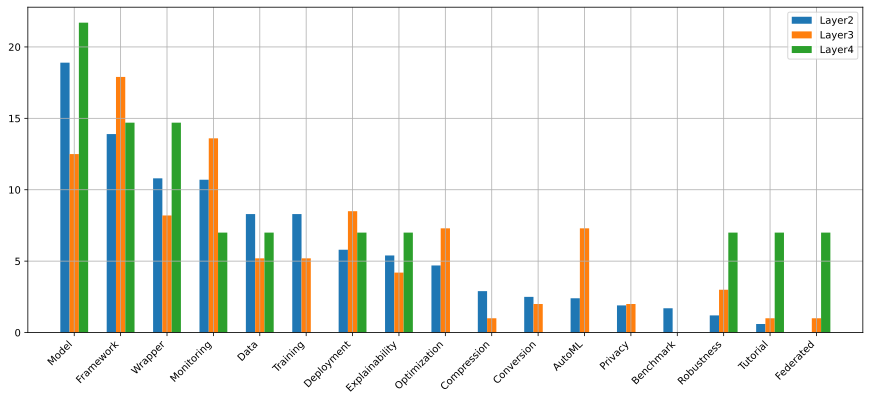

In [18]:
fig = plt.figure(figsize=(15, 6))
ndr_names = ['Model', 'Framework', 'Wrapper', 'Monitoring', 'Data', 'Training', 'Deployment', 'Explainability', 'Optimization', 
             'Compression', 'Conversion', 'AutoML', 'Privacy', 'Benchmark', 'Robustness', 'Tutorial', 'Federated']
b1 = plt.bar([0.8+i for i in range(0, len(ndr_names))], [ndr_results[v][0] for v in ndr_names], width=0.2)
b2 = plt.bar([1+i for i in range(0, len(ndr_names))], [ndr_results[v][1] for v in ndr_names], width=0.2)
b3 = plt.bar([1.2+i for i in range(0, len(ndr_names))], [ndr_results[v][2] for v in ndr_names], width=0.2)
# plt.bar([1, 2, 3, 4], [4, 5, 6, 7], bottom=[4, 5, 6, 7], width=0.3)
 
plt.xlim(0, 18)
plt.xticks(list(range(1, len(ndr_names) + 1)), ndr_names, rotation=45, horizontalalignment='right')
plt.grid(True)
 
plt.legend((b1, b2, b3), ('Layer2', 'Layer3', 'Layer4'))
plt.savefig('figures/ndr_categories.pdf', bbox_inches='tight') 
plt.show()